# PascalPart Object Detection Test

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for Pascalpart

Let's write a dataset for the Penn-Fudan dataset.

First, let's download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

Let's have a look at the dataset and how it is layed down.

Here is one example of an image in the dataset, with its corresponding instance segmentation mask

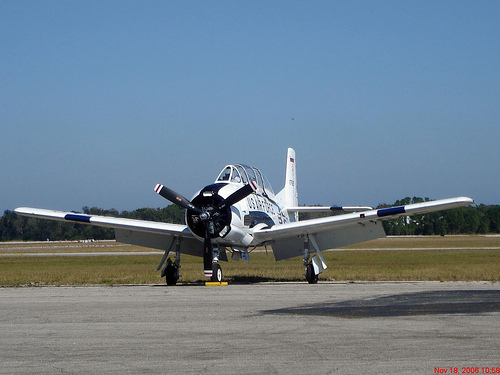

In [1]:
import os
import numpy as np
from PIL import Image

im = Image.open('data/PascalPart/Images/2008_000021.jpg')
# np.asarray(im).shape
im

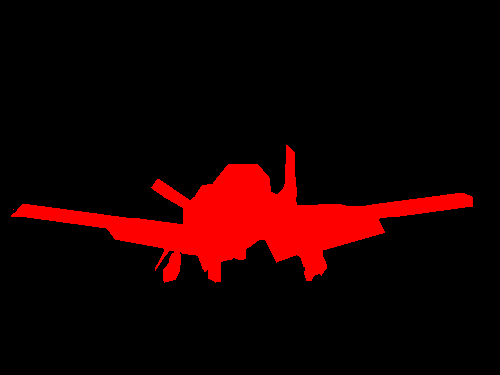

In [2]:
import pickle
with open('data/PascalPart/Masks/2008_000021_mask.pckl', 'rb') as f:
    mask = pickle.load(f)

mask_image = Image.fromarray(mask[0])
mask_image.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    0, 0, 255, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask_image

In [3]:
from pascalpart import PascalPartDataset

num_objs = mask.shape[0]
# get bounding box coordinates for each mask
boxes = []
for i in range(num_objs):
    pos = np.where(mask[i] !=0)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])
print(boxes)

# The number of instances present in each image is given by the numbers of unique id assigned to each pixel (with 0 being the background)
np.unique(np.asarray(mask))

[[11, 145, 472, 282], [151, 164, 288, 265], [250, 193, 472, 262], [11, 204, 205, 255], [163, 261, 175, 282], [304, 263, 316, 280], [208, 260, 220, 282], [276, 145, 368, 218]]


array([ 0,  1,  2, 56, 63, 65], dtype=uint8)

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

That's all for the dataset. Let's see how the outputs are structured for this dataset

{'boxes': tensor([[ 47., 203.,  93., 235.],
        [ 75., 228.,  80., 231.],
        [ 59., 206.,  92., 231.],
        [ 47., 204.,  59., 231.],
        [ 57., 203.,  84., 206.],
        [ 89., 213.,  93., 215.],
        [ 52., 213.,  57., 216.],
        [ 56., 227.,  60., 235.],
        [ 48., 227.,  52., 234.],
        [ 86., 230.,  92., 235.],
        [ 60., 207.,  89., 215.],
        [156., 197., 228., 239.],
        [202., 223., 218., 227.],
        [195., 200., 228., 228.],
        [157., 200., 196., 227.],
        [165., 209., 166., 212.],
        [180., 223., 188., 237.],
        [156., 223., 165., 236.],
        [213., 229., 224., 239.],
        [196., 201., 225., 210.],
        [172., 201., 195., 210.]]), 'labels': tensor([[14],
        [47],
        [27],
        [50],
        [51],
        [38],
        [38],
        [63],
        [63],
        [63],
        [64],
        [14],
        [47],
        [ 4],
        [36],
        [38],
        [63],
        [63],
        [63]

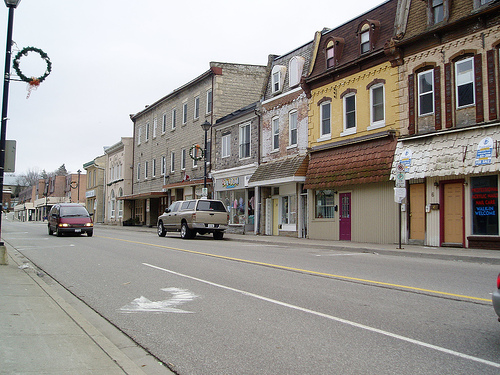

In [12]:
dataset = PascalPartDataset('data/PascalPart/')
image, target = dataset[12]
print(target)
image

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes):
    # load an object recognizer model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook


Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [7]:
import vision_utils.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [8]:
from vision_utils import utils
import torch
# use our dataset and defined transformations
dataset = PascalPartDataset('data/PascalPart', get_transform(train=True))
dataset_test = PascalPartDataset('data/PascalPart/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
n_train = int(np.round(len(indices) * 90 / 100))
dataset = torch.utils.data.Subset(dataset, indices[:n_train])
dataset_test = torch.utils.data.Subset(dataset_test, indices[n_train:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [9]:
from pascalpart import name_ids

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 66 classes
num_classes = len(name_ids)

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [10]:
# data = next(iter(data_loader))[0][0]
# data = torch.unsqueeze(data, dim=0)
# # data
# extracted_feat = model.backbone(data)
# extracted_feat

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [11]:
from vision_utils.engine import train_one_epoch, evaluate

# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


RuntimeError: 1D target tensor expected, multi-target not supported

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [ ]:
im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
im

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
from PIL import ImageDraw
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
for box, score in zip(boxes, scores):
  if score > 0.5:
    print(score)
    ImageDraw.Draw(im).rectangle(box)
im

# Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection).

